In [1]:
!pip install yfinance 

In [2]:
import yfinance as yf 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [5]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [6]:
data = yf.download('BTC-USD','2018-01-01','2021-06-30') 

[*********************100%***********************]  1 of 1 completed


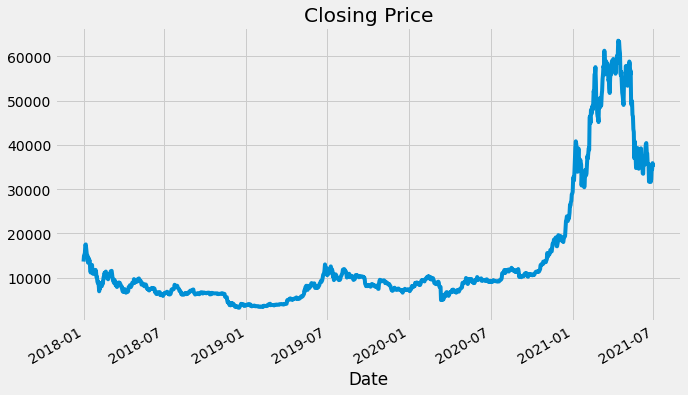

In [7]:

data.Close.plot() 
plt.title('Closing Price')
plt.show()

In [8]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072


In [9]:
data1=data.reset_index()

In [10]:
data1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
1,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
3,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
4,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1273 entries, 2018-01-01 to 2021-06-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1273 non-null   float64
 1   High       1273 non-null   float64
 2   Low        1273 non-null   float64
 3   Close      1273 non-null   float64
 4   Adj Close  1273 non-null   float64
 5   Volume     1273 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 69.6 KB


In [12]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1273.000000,1273.000000,1273.000000,1273.000000,1273.000000,1.273000e+03
mean,13967.695874,14356.665353,13525.776158,13982.179586,13982.179586,2.435492e+10
std,13947.396599,14405.273120,13396.765318,13957.203167,13957.203167,2.212821e+10
min,3236.274658,3275.377930,3191.303467,3236.761719,3236.761719,2.923670e+09
25%,6739.209961,6872.410156,6595.918457,6734.950195,6734.950195,6.917930e+09
50%,8939.269531,9197.546875,8787.250977,8930.879883,8930.879883,1.866864e+10
75%,11485.608398,11790.916992,11216.872070,11488.363281,11488.363281,3.458560e+10
max,63523.753906,64863.097656,62208.964844,63503.457031,63503.457031,3.509679e+11


In [13]:
n,p=data.shape
print(n,p)

1273 6


In [14]:
data.isnull().sum()*100/n

Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

In [15]:
type(data1)

pandas.core.frame.DataFrame

In [16]:
df_adj_close = data1[["Adj Close"]]


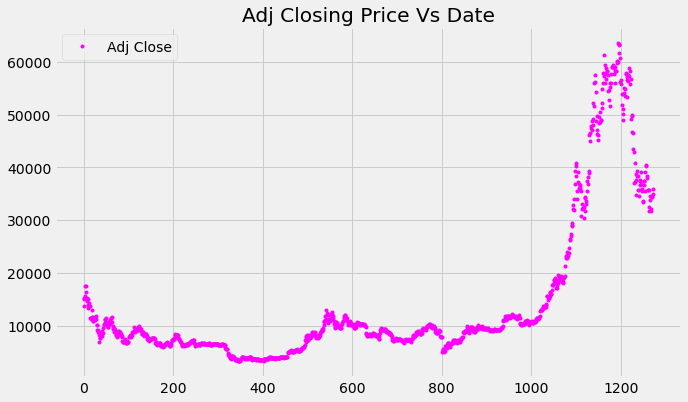

In [17]:
df_adj_close.plot(style='k.',c='magenta')
plt.title('Adj Closing Price Vs Date')
plt.show()

In [18]:
def detect(signal, treshold = 2.0):
    detected = []
    for i in range(len(signal)):
        if np.abs(signal[i]) > treshold:
            detected.append(i)
    return detected

In [19]:
signal = np.copy(data1['Adj Close'].values)
std_signal = (signal - np.mean(signal)) / np.std(signal)
s = pd.Series(std_signal)
s.describe(percentiles = [0.25, 0.5, 0.75, 0.95])

count    1.273000e+03
mean    -2.616394e-16
std      1.000393e+00
min     -7.701859e-01
25%     -5.194506e-01
50%     -3.620557e-01
75%     -1.787462e-01
95%      2.738432e+00
max      3.549475e+00
dtype: float64

In [20]:
outliers = detect(std_signal, 1.3)

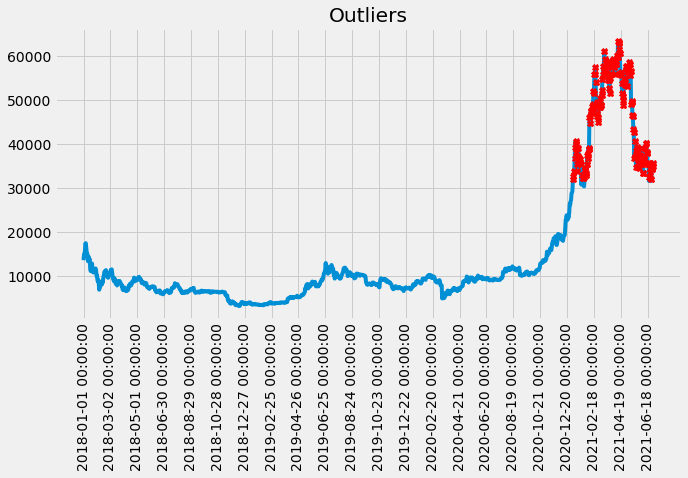

In [21]:
plt.figure(figsize = (10, 5))
plt.plot(np.arange(len(signal)), signal)
plt.title('Outliers')
plt.plot(np.arange(len(signal)),signal,'X',label = 'outliers',markevery = outliers,c = 'r',)
plt.xticks(np.arange(len(signal))[::60],data1['Date'][::60], rotation = 90)
plt.show()

# Fitting LSTM Model

In [85]:
#Creating a Dataframe with the variable for analysis
dataframe = data1[["Adj Close"]]

#dataframe=dataframe.set_index('Date')

In [50]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273 entries, 0 to 1272
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1273 non-null   float64
dtypes: float64(1)
memory usage: 10.1 KB


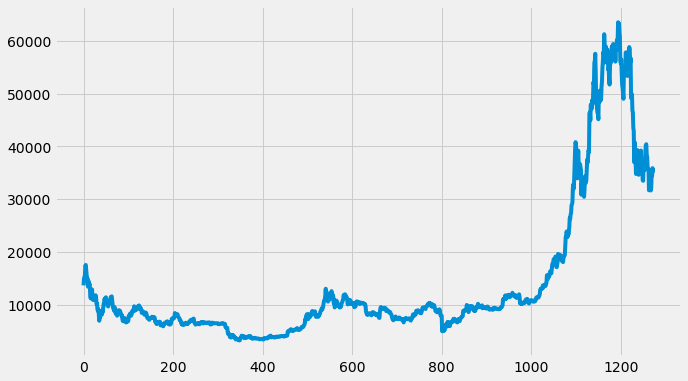

In [23]:
plt.plot(dataframe)

In [24]:
#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32')

In [55]:
dataset[:10]

array([[0.17290543],
       [0.19488937],
       [0.19852155],
       [0.20512885],
       [0.23549888],
       [0.23711666],
       [0.21970406],
       [0.19800884],
       [0.1884729 ],
       [0.19474335]], dtype=float32)

In [25]:
# Normalization of the data using MinMaxScalar
scaler = MinMaxScaler(feature_range=(0, 1)) 
dataset = scaler.fit_transform(dataset)

In [48]:
#Splitting into Train (80%) and Test(20%)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train_size)
print(test_size)

1018
255


In [27]:
#Use TimeseriesGenerator to organize training data into the right format
from keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data
seq_size = length =  10 
batch_size = 1
train_generator = TimeseriesGenerator(train,train,length=length,batch_size=batch_size)
print("Total number of samples in the original training data = ", len(train)) 
print("Total number of samples in the generated data = ", len(train_generator))

Total number of samples in the original training data =  1018
Total number of samples in the generated data =  1008


In [53]:
 train_generator[0]

(array([[[0.17290543],
         [0.19488937],
         [0.19852155],
         [0.20512885],
         [0.23549888],
         [0.23711666],
         [0.21970406],
         [0.19800884],
         [0.1884729 ],
         [0.19474335]]], dtype=float32),
 array([[0.16873395]], dtype=float32))

In [28]:
x, y = train_generator[0]

In [29]:
#Also generate validation data
validation_generator = TimeseriesGenerator(test, test, length=length ,batch_size=batch_size)

In [30]:
#Input dimensions are... (N x seq_size)
num_features = 1 #Univariate example

In [33]:
#reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [34]:
#LSTM single layer with 50 units
model = Sequential()

model.add(LSTM(50, input_shape=(length, num_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.fit_generator(generator=train_generator, verbose=2, epochs=100, validation_data=validation_generator)

/Users/e_kattoor/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1008/1008 - 12s - loss: 2.0855e-04 - val_loss: 0.0040
Epoch 2/100
1008/1008 - 3s - loss: 8.2570e-05 - val_loss: 0.0032
Epoch 3/100
1008/1008 - 2s - loss: 6.7884e-05 - val_loss: 0.0033
Epoch 4/100
1008/1008 - 2s - loss: 5.3454e-05 - val_loss: 0.0023
Epoch 5/100
1008/1008 - 2s - loss: 4.7865e-05 - val_loss: 0.0043
Epoch 6/100
1008/1008 - 2s - loss: 4.6346e-05 - val_loss: 0.0035
Epoch 7/100
1008/1008 - 3s - loss: 4.4209e-05 - val_loss: 0.0062
Epoch 8/100
1008/1008 - 3s - loss: 4.3673e-05 - val_loss: 0.0088
Epoch 9/100
1008/1008 - 2s - loss: 4.1557e-05 - val_loss: 0.0036
Epoch 10/100
1008/1008 - 3s - loss: 4.2744e-05 - val_loss: 0.0033
Epoch 11/100
1008/1008 - 2s - loss: 4.4483e-05 - val_loss: 0.0032
Epoch 12/100
1008/1008 - 3s - loss: 4.4773e-05 - val_loss: 0.0045
Epoch 13/100
1008/1008 - 2s - loss: 4.2762e-05 - val_loss: 0.0061
Epoch 14/100
1008/1008 - 2s - loss: 4.3345e-05 - val_loss: 0.0034
Epoch 15/100
1008/1008 - 2s - loss: 4.0610e-05 - val_loss: 0.0078
Epoch 16/100
1008/

In [37]:
trainPredict = model.predict(train_generator)
testPredict = model.predict(validation_generator)

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform(train)
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform(test)

In [89]:
len(testPredict)

245

In [38]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inverse[length:], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inverse[length:], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 335.02 RMSE
Test Score: 12757.22 RMSE


In [39]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[length:len(trainPredict)+length, :] = trainPredict

In [40]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train)+(length)-1:len(dataset)-1, :] = testPredict

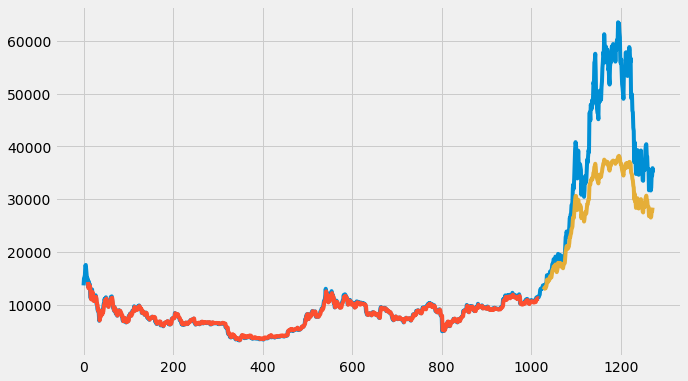

In [41]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [43]:
print(trainPredict)

[[14307.048]
 [13118.728]
 [13437.515]
 ...
 [11248.799]
 [11110.463]
 [11125.729]]


In [44]:
print(testPredict)

[[12863.104 ]
 [12971.641 ]
 [13067.456 ]
 [13260.667 ]
 [13244.059 ]
 [13098.383 ]
 [13398.08  ]
 [13566.45  ]
 [14692.338 ]
 [14769.876 ]
 [14252.744 ]
 [14694.042 ]
 [14615.804 ]
 [14586.227 ]
 [14887.654 ]
 [15338.383 ]
 [15413.0625]
 [15249.95  ]
 [15156.263 ]
 [15701.483 ]
 [16410.504 ]
 [16593.137 ]
 [16643.504 ]
 [17216.697 ]
 [17281.01  ]
 [17126.6   ]
 [17112.734 ]
 [17616.291 ]
 [17402.248 ]
 [16319.704 ]
 [16169.238 ]
 [16547.605 ]
 [16893.914 ]
 [17927.06  ]
 [17461.242 ]
 [17741.035 ]
 [17907.914 ]
 [17438.775 ]
 [17712.574 ]
 [17842.488 ]
 [17764.62  ]
 [17174.414 ]
 [17275.295 ]
 [17060.043 ]
 [16902.863 ]
 [17391.188 ]
 [17653.107 ]
 [17765.998 ]
 [17901.57  ]
 [19171.496 ]
 [20207.135 ]
 [20555.623 ]
 [21092.105 ]
 [20925.803 ]
 [20554.34  ]
 [21103.758 ]
 [20798.984 ]
 [21113.676 ]
 [21659.465 ]
 [22738.336 ]
 [22757.414 ]
 [23299.854 ]
 [23487.545 ]
 [24341.033 ]
 [24497.396 ]
 [24786.658 ]
 [26179.129 ]
 [26600.389 ]
 [26411.576 ]
 [27358.354 ]
 [28622.598 ]
 [2982

In [47]:
len(testPredict)

245

# Stacked LSTM

In [58]:
#Creating a Dataframe with the variable for analysis
dataframe1 = data1[["Adj Close"]]
#dataframe=dataframe.set_index('Date')

In [59]:
dataset1 = dataframe1.values
dataset1 = dataset1.astype('float32')

In [60]:
# normalize the dataset
scaler1 = MinMaxScaler(feature_range=(0, 1)) 
dataset1 = scaler.fit_transform(dataset1)

In [62]:
# split into train and test sets
train_size1 = int(len(dataset1) * 0.80)
test_size1 = len(dataset1) - train_size1
train1, test1 = dataset1[0:train_size1,:], dataset[train_size1:len(dataset1),:]

In [65]:
from keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data
seq_size1 = length1 =  10 
batch_size = 1
train_generator1 = TimeseriesGenerator(train1,train1,length=length1,batch_size=batch_size1)
print("Total number of samples in the original training data = ", len(train1))
print("Total number of samples in the generated data = ", len(train_generator1))

Total number of samples in the original training data =  1018
Total number of samples in the generated data =  1008


In [66]:
x1, y1 = train_generator1[0]

In [68]:
#Also generate validation data
validation_generator1 = TimeseriesGenerator(test1, test1, length=length1 ,batch_size=batch_size1)

In [69]:

#Input dimensions are... (N x seq_size)
num_features1 = 1 

In [70]:

#Stacked LSTM with 1 hidden dense layer


model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(length1, num_features1)))
model.add(LSTM(50, activation='relu'))
#model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
print('Train...')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Train...


In [71]:
model.fit_generator(generator=train_generator1, verbose=2, epochs=100, validation_data=validation_generator1)

/Users/e_kattoor/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1008/1008 - 11s - loss: 3.0555e-04 - val_loss: 0.0157
Epoch 2/100
1008/1008 - 4s - loss: 1.3429e-04 - val_loss: 0.0249
Epoch 3/100
1008/1008 - 4s - loss: 1.0659e-04 - val_loss: 0.0414
Epoch 4/100
1008/1008 - 4s - loss: 9.4129e-05 - val_loss: 0.0419
Epoch 5/100
1008/1008 - 4s - loss: 7.8667e-05 - val_loss: 0.0316
Epoch 6/100
1008/1008 - 4s - loss: 6.6724e-05 - val_loss: 0.0246
Epoch 7/100
1008/1008 - 4s - loss: 7.0787e-05 - val_loss: 0.0340
Epoch 8/100
1008/1008 - 4s - loss: 5.9714e-05 - val_loss: 0.0418
Epoch 9/100
1008/1008 - 4s - loss: 5.1942e-05 - val_loss: 0.0292
Epoch 10/100
1008/1008 - 4s - loss: 5.0584e-05 - val_loss: 0.0342
Epoch 11/100
1008/1008 - 4s - loss: 4.5791e-05 - val_loss: 0.0422
Epoch 12/100
1008/1008 - 4s - loss: 4.5186e-05 - val_loss: 0.0355
Epoch 13/100
1008/1008 - 4s - loss: 4.5123e-05 - val_loss: 0.0520
Epoch 14/100
1008/1008 - 4s - loss: 4.4945e-05 - val_loss: 0.0425
Epoch 15/100
1008/1008 - 4s - loss: 4.2204e-05 - val_loss: 0.0504
Epoch 16/100
1008/

In [72]:
trainPredict1 = model.predict(train_generator1)
testPredict1 = model.predict(validation_generator1)

trainPredict1 = scaler.inverse_transform(trainPredict1)
trainY_inverse1 = scaler.inverse_transform(train1)

testPredict1 = scaler.inverse_transform(testPredict1)
testY_inverse1 = scaler.inverse_transform(test1)

In [83]:
len(testPredict1)

245

In [73]:
# calculate root mean squared error
trainScore1 = math.sqrt(mean_squared_error(trainY_inverse1[length:], trainPredict1[:,0]))
print('Train Score: %.2f RMSE' % (trainScore1))

Train Score: 342.04 RMSE


In [74]:
testScore1 = math.sqrt(mean_squared_error(testY_inverse1[length:], testPredict1[:,0]))
print('Test Score: %.2f RMSE' % (testScore1))

Test Score: 10621.54 RMSE


In [75]:
trainPredictPlot1 = np.empty_like(dataset1)
trainPredictPlot1[:, :] = np.nan
trainPredictPlot1[length:len(trainPredict1)+length1, :] = trainPredict1

In [80]:
testPredictPlot1 = np.empty_like(dataset1)
testPredictPlot1[:, :] = np.nan
testPredictPlot1[len(train1)+(length1)-1:len(dataset1)-1, :] = testPredict1

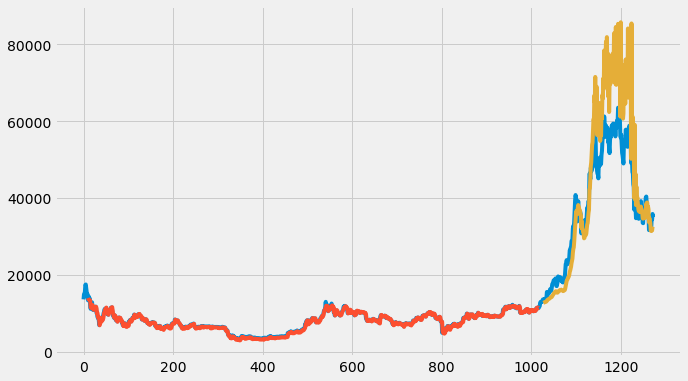

In [81]:
plt.plot(scaler.inverse_transform(dataset1))
plt.plot(trainPredictPlot1)
plt.plot(testPredictPlot1)
plt.show()